In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.17.0
GPU available: []


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

base_model = inception_v3.InceptionV3(weights='imagenet', include_top=False)
print("Model Loaded with", len(base_model.layers), "layers.")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Model Loaded with 311 layers.


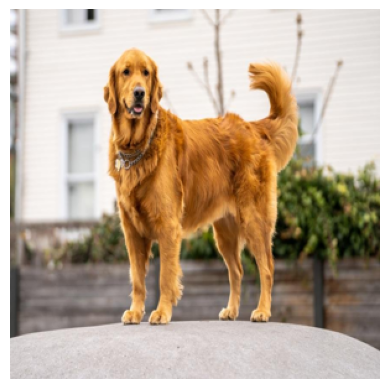

In [6]:
img_path = "../data/TestImg1.jpeg"
img = Image.open(img_path)
img = img.resize((299, 299))
plt.imshow(img)
plt.axis('off')
plt.show()

x = np.array(img)
x = np.expand_dims(x, axis=0)
x = inception_v3.preprocess_input(x)

In [7]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)


0 input_layer
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_

Activation shape: (1, 35, 35, 288)


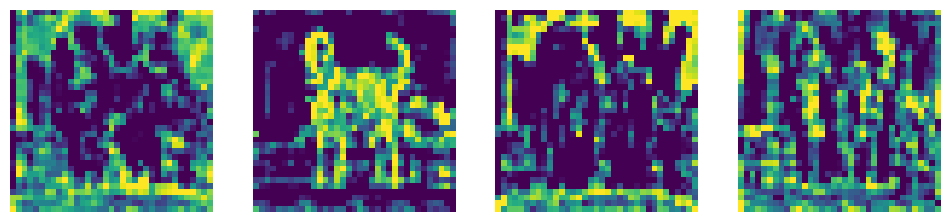

In [15]:
layer_name = 'mixed1'
intermediate_layer_model = tf.keras.Model(inputs=base_model.input,
                                          outputs=base_model.get_layer(layer_name).output)
activations = intermediate_layer_model(x)

print("Activation shape:", activations.shape)

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    act = activations[0, :, :, i].numpy()
    act = (act - np.mean(act)) / (np.std(act) + 1e-5)
    act = np.clip((act * 64 + 128), 0, 255).astype('uint8')
    axes[i].imshow(act, cmap='viridis')
    axes[i].axis('off')
plt.show()


In [ ]:
#choosing diff layers that we'll use in DeepDream
dream_layers = ['mixed1', 'mixed3', 'mixed5', 'mixed7']

outputs = [base_model.get_layer(name).output for name in dream_layers]
dream_model = tf.keras.Model(inputs=base_model.input, outputs=outputs)


In [ ]:
def calc_loss(img, model):
    # adding batch dimension
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if not isinstance(layer_activations, list):
        layer_activations = [layer_activations]

    losses = []
    for act in layer_activations:
        loss = tf.reduce_mean(act[:, 2:-2, 2:-2, :])
        losses.append(loss)
    return tf.reduce_sum(losses)


In [ ]:
@tf.function
def gradient_ascent_step(img, model, step_size):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = calc_loss(img, model)
    gradients = tape.gradient(loss, img)
    # normalizing the gradients
    gradients = gradients / (tf.math.reduce_std(gradients) + 1e-8)
    img = img + gradients * step_size
    img = tf.clip_by_value(img, -1, 1)
    return img, loss


In [19]:
def run_deep_dream(img, model, steps=100, step_size=0.01):
    img = tf.convert_to_tensor(img)
    for step in range(steps):
        img, loss = gradient_ascent_step(img, model, step_size)
        if step % 20 == 0:
            print(f"Step {step}, Loss {loss.numpy():.4f}")
    return img


Step 0, Loss 1.2569
Step 20, Loss 2.4092
Step 40, Loss 2.7849
Step 60, Loss 3.0207
Step 80, Loss 3.2063


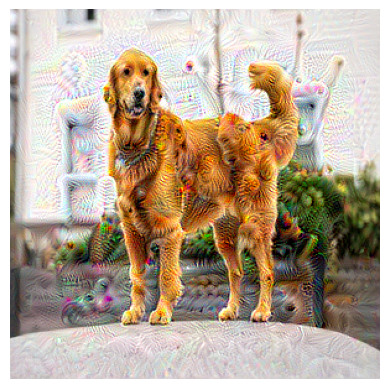

In [ ]:
def deprocess(img):
    img = 255 * (img + 1.0) / 2.0
    return tf.cast(tf.clip_by_value(img, 0, 255), tf.uint8)

# preprocess the image
original_img = Image.open("../data/TestImg1.jpeg")
original_img = original_img.resize((299, 299))
img = np.array(original_img)
img = inception_v3.preprocess_input(img)

dreamed = run_deep_dream(img, dream_model, steps=100, step_size=0.01)
plt.imshow(deprocess(dreamed).numpy())
plt.axis('off')
plt.show()


In [21]:
def resize_img(img, size):
    """Resize tensor image to given size."""
    img = tf.image.resize(img, size)
    return img

def show_image(img, title=None):
    """Deprocess and display an image tensor."""
    img = deprocess(img).numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()


In [24]:
def run_deep_dream_octaves(img, model, 
                           step_size=0.01, steps_per_octave=100, 
                           octaves=3, octave_scale=1.4):
    """Applying DeepDream over multiple image sizes."""
    base_shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    float_img = tf.convert_to_tensor(img)

    for octave in range(octaves):
        new_size = tf.cast(base_shape * (octave_scale ** octave), tf.int32)
        float_img = resize_img(float_img, new_size)
        print(f"Octave {octave+1}/{octaves} | size {new_size.numpy().tolist()}")
        float_img = run_deep_dream(float_img, model, 
                                   steps=steps_per_octave, 
                                   step_size=step_size)
    return float_img


Octave 1/3 | size [299, 299]
Step 0, Loss 1.2569
Step 20, Loss 2.4092
Step 40, Loss 2.7849
Step 60, Loss 3.0207
Octave 2/3 | size [418, 418]
Step 0, Loss 1.4115
Step 20, Loss 2.5982
Step 40, Loss 2.9416
Step 60, Loss 3.1620
Octave 3/3 | size [586, 586]
Step 0, Loss 1.3757
Step 20, Loss 2.5514
Step 40, Loss 2.9043
Step 60, Loss 3.1272


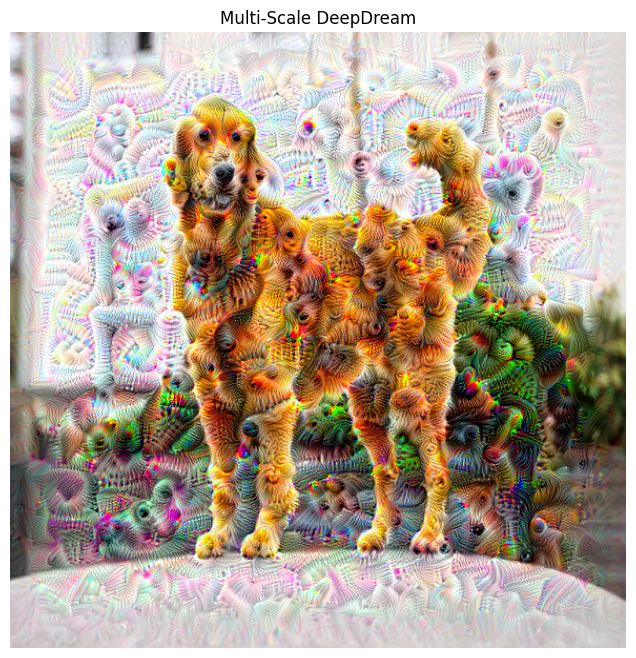

In [25]:
#preprocess original image
original_img = Image.open("../data/TestImg1.jpeg").resize((299, 299))
img = np.array(original_img)
img = inception_v3.preprocess_input(img)

dreamed_oct = run_deep_dream_octaves(
    img, 
    dream_model, 
    step_size=0.01, 
    steps_per_octave=80, 
    octaves=3, 
    octave_scale=1.4
)

show_image(dreamed_oct, title="Multi-Scale DeepDream")


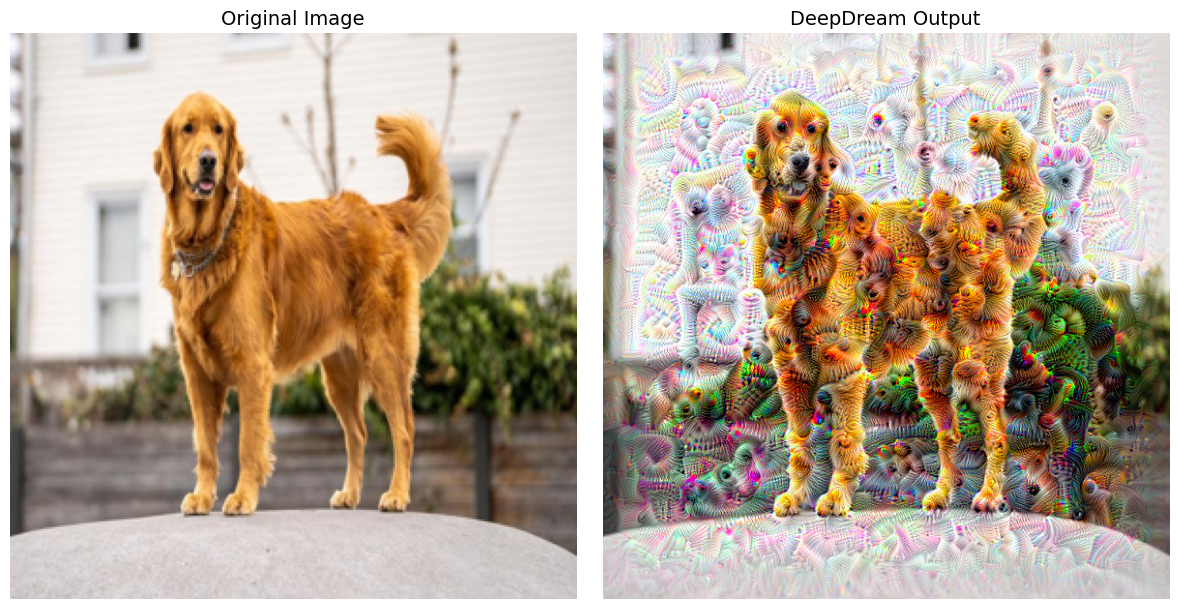

In [ ]:
# Compare Original vs DeepDream Output

# reload the og img
orig = Image.open("../data/TestImg1.jpeg").resize((299, 299))
orig_np = np.array(orig)

# deprocess the dreamed img
dream_np = deprocess(dreamed_oct).numpy()

# plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(orig_np)
axes[0].set_title("Original Image", fontsize=14)
axes[0].axis("off")

axes[1].imshow(dream_np)
axes[1].set_title("DeepDream Output", fontsize=14)
axes[1].axis("off")

plt.tight_layout()
plt.show()
